In [1]:
!pip install -U ppscore

  Created wheel for ppscore: filename=ppscore-1.1.1-py2.py3-none-any.whl size=12986 sha256=0340d4a4656237ab107e95f362f35094f1d13a7144d7bf8fd6b13e4648352744
  Stored in directory: /root/.cache/pip/wheels/d0/1f/c4/e619fb20c9b10df8ddde15d583197edef8c2f27d7b1f29c633
Successfully built ppscore
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import ppscore as pps

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")
pd.options.plotting.backend = "plotly"

data = pd.read_csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')

# Content

<ul style="font-size: 18px">
    <li>Facts related to heart Failure</li>
    <li>Description of Data</li>
    <li>Correlation in the Data</li>
    <li>Outliers in Data</li>
    <li>Relation between variables</li>
    <li>Pairplot</li>
    <li>Standardizing data</li>
    <li>Deciding Model</li>
    <li>Splitting the Data</li>
    <li>DT Classifier</li>
    <li>RF Classifier</li>
    <li>Comparison of Models</li>
    <li>Conclusion</li>
</ul>

<h1>Heart Failure</h1>

<p>Heart failure happens when the heart cannot pump enough blood and oxygen to support other organs in your body. Heart failure is a serious condition, but it does not mean that the heart has stopped beating.</p>

<h1>Facts About Heart Failure</h1>

<ul>
    <li>About 6.5 million adults in the United States have heart failure.</li>
    <li>Heart failure was a contributing cause of 1 in 8 deaths in 2017.</li>
    <li>Heart failure costs the nation an estimated $30.7 billion in 2012. This total includes the cost of health care services, medicines to treat heart failure, and missed days of work.<a href="https://www.cdc.gov/heartdisease/heart_failure.htm">Source</a></li>
</ul>

<img src="https://timesofindia.indiatimes.com/thumb/msid-71058199,width-1200,height-900,resizemode-4/.jpg" height="500px" width="500px">

# Description of Data

In [3]:
fig = data.nunique().reset_index().plot(kind='bar', x='index', y=0, color=0)
fig.update_layout(title='Unique Value Count Plot', xaxis_title='Variables', yaxis_title='Unique value count')
fig.show()

In [4]:
fig = data.isnull().sum().reset_index().plot(kind='bar', x='index', y=0)
fig.update_layout(title='Missing Value Plot', xaxis_title='Variables', yaxis_title='Missing value count')
fig.show()

<p style="font-size:18px">No missing values present. That's a good news. Let's check the data types as well to make sure variables don't have mized type of data here.</p>

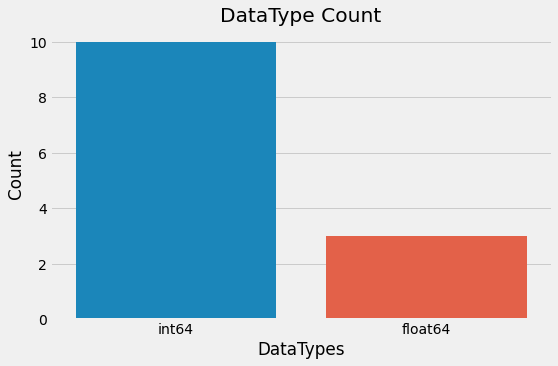

In [5]:
df = data.dtypes.value_counts().reset_index()
df['index'] = df['index'].astype('str')
sns.barplot(df['index'], df[0])
plt.title('DataType Count')
plt.xlabel('DataTypes')
plt.ylabel('Count')
plt.show()

# Correlation in the data

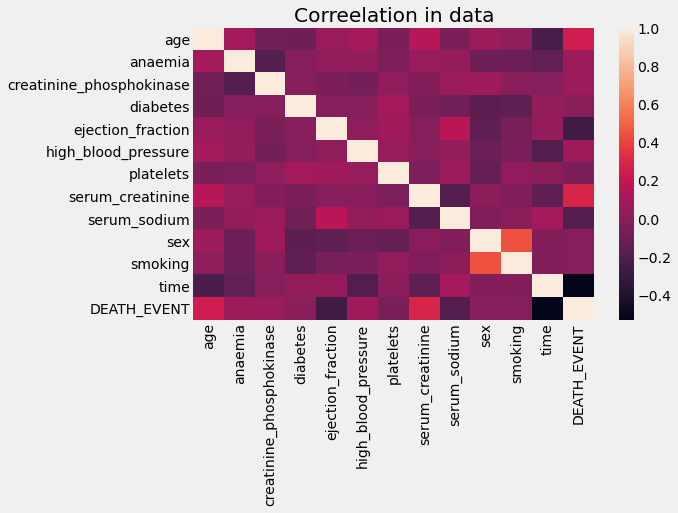

In [6]:
sns.heatmap(data.corr())
plt.title('Correelation in data')
plt.show()

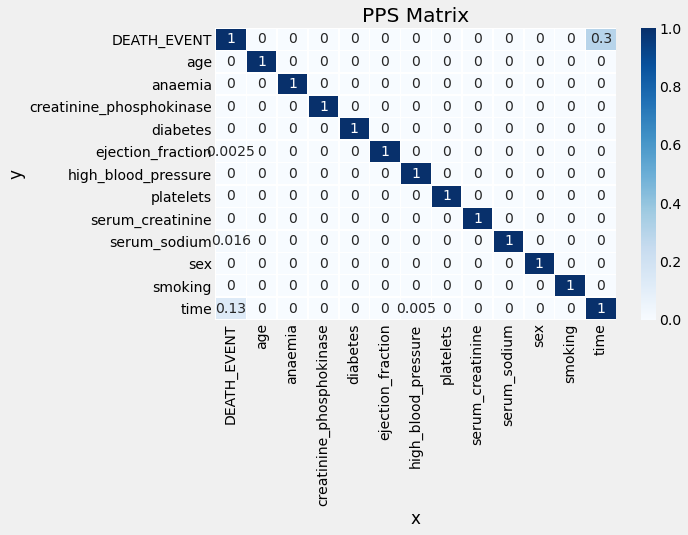

In [7]:
matrix_df = pps.matrix(data)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.title('PPS Matrix')
plt.show()

# Outliers in the data

<p style="font-size:17px">The variables which I will need to check for outliers are mostly the continuous variables and not the categorical ones.<br><br>Since I have already confirmed the datatypes, categorical variables are already clean.<br><br>
So i will check thing for age, creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium and time</p>

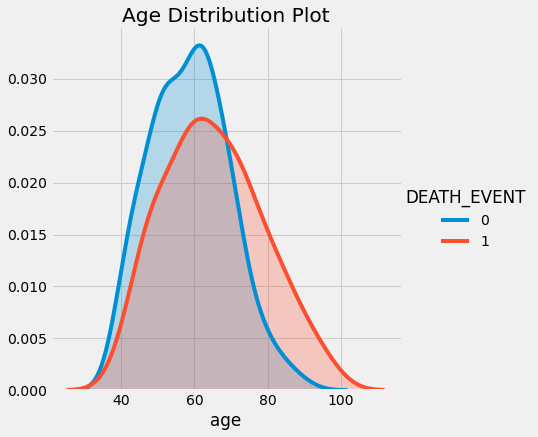

In [8]:
sns.FacetGrid(data, hue="DEATH_EVENT", height=6,).map(sns.kdeplot, "age",shade=True).add_legend()
plt.title('Age Distribution Plot')
plt.show()

In [9]:
px.box(data, x='DEATH_EVENT', y='creatinine_phosphokinase', color='smoking', title='Creatinine Phosphokinase Distribution')

<p style="font-size:18px">The variable creatinine_phosphokinase possibly denotes the amount of creatinine phosphokinase(an enzyme in human body) in the body of the person tested.<br><br>From the above plot it can be inferred that any amount of the enzyme higher than 4000 is an outlier.</p>

In [10]:
px.violin(data, x='ejection_fraction', color='DEATH_EVENT', title='Ejection Fraction Distribution')

In [11]:
px.box(data, x='DEATH_EVENT', y='platelets', color='diabetes', points='all', title='Platelets Distribution')

In [12]:
px.box(data, x='DEATH_EVENT', y='time', color='smoking', notched=True, title='Time under observation Distribution')

# Relation in the data

<p style="font-size:18px">From general convention the relation among the variables that might be interesting are<br><br>1. high_blood_pressure and platelets<br>2. diabetes, serum_sodium and serum_creatinine<br>3. time and DEATH_EVENT</p>

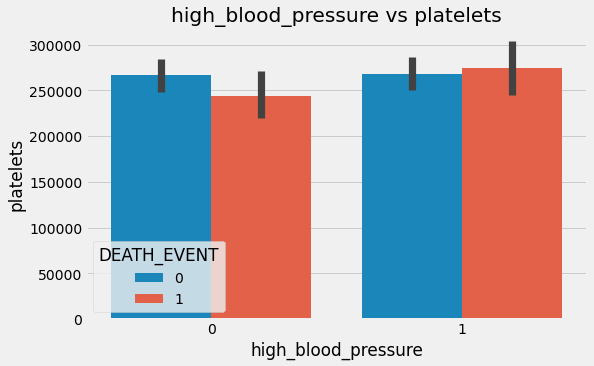

In [13]:
sns.barplot(data=data, x='high_blood_pressure', y='platelets', hue='DEATH_EVENT')
plt.title('high_blood_pressure vs platelets')
plt.show()

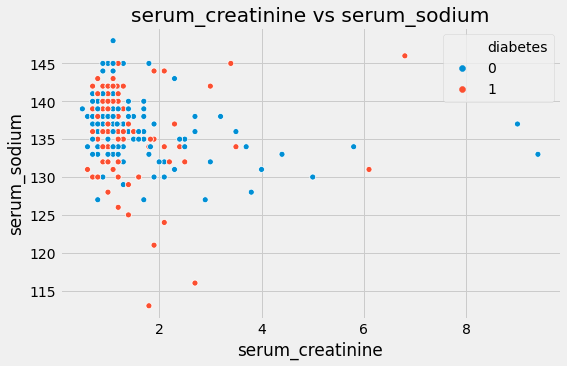

In [14]:
sns.scatterplot(data=data, x='serum_creatinine', y='serum_sodium', hue='diabetes')
plt.title('serum_creatinine vs serum_sodium')
plt.show()

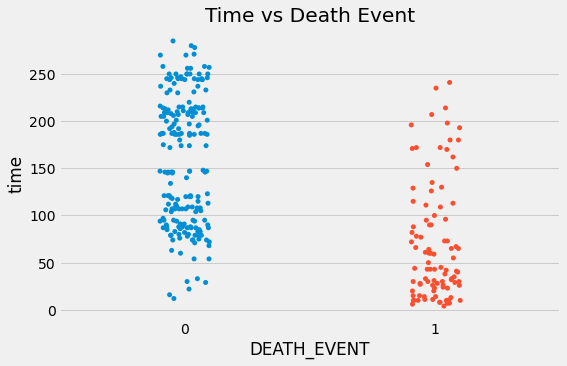

In [15]:
sns.stripplot(data=data, x="DEATH_EVENT", y="time")
plt.title('Time vs Death Event')
plt.show()

# Pairplot

<p style="font-size:18px">The pairplot below is for checking the relation between all the continuous variables as it will help in deciding the model.</p>

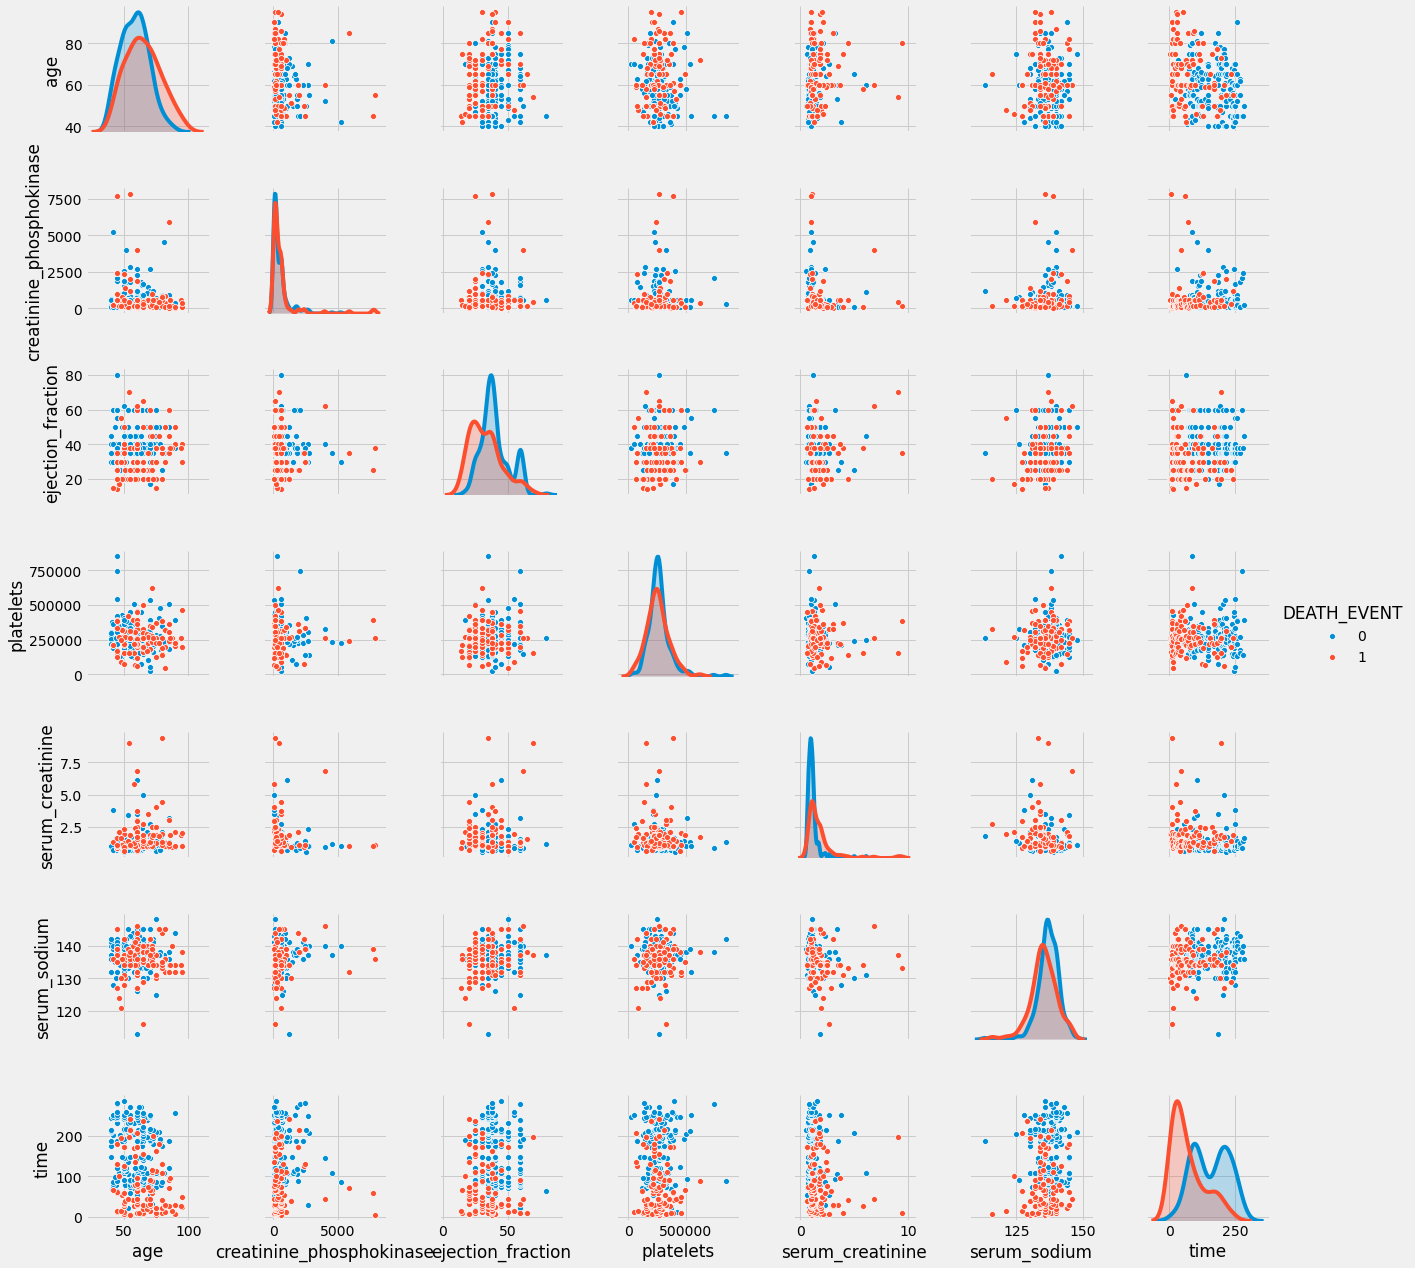

In [16]:
sns.pairplot(data=data[['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time','DEATH_EVENT']], hue='DEATH_EVENT')

# Standardizing the data

<p style="font-size:18px">The variables that needs to be standardized are age, creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium, and time.<br><br>Leaving out the categorical variables.<br><br>I will be using the StandardScaler module provided by the sklearn api</p>

In [17]:
from sklearn.preprocessing import StandardScaler

cols = ['age','creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

In [18]:
scaler = StandardScaler()
data[cols] = scaler.fit_transform(data[cols])

<p style="font-size:18px">Since the number of dimensions in the data isn't much high, we don't need any dimensionality reduction in this case.</p>

# Deciding Model

<p style="font-size:18px">If we look at a glance at the data then it will seem that the data contains very few number of observations.<br><br>But if looked closely the number of observations is still a lot more than the number of features.<br><br>So there is a chance that low bias/high variance algorithms like KNN, Decision Trees and kernel SVM will perform better on this type of data.<br><br>Also if I use decision trees I won't needs to process the binary categorical variables in the data.</p>

<p style="font-size:18px">Now in this case since it is a prediction of whether or not a person has chances of heart attack, high accuracy is the main goal whatsoever.<br><br>So in this I will be using a flexible model since the interpretability can be sacrificed.</p>

<p style="font-size:18px">Since the number of observations is not much high them it is quite feasible to use any algorithm without worrying much about the speed or training time.<br><br>In our case most of the variables are not very much linear so it will not be a good idea to use logistic regression or SVM. Rather models like random forest or neural net will be better.<br><br>I will be using decision tree classifier and random forest classifier on the data.</p>

# Splitting the data

In [19]:
X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT'].copy()

In [20]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=13)

Let's get the model checking metric modules as well

In [21]:
from sklearn.metrics import roc_curve,accuracy_score,plot_confusion_matrix

# Decision Tree CLassifier

In [22]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(min_samples_split=2, class_weight={0:2,1:7}, random_state=13)
model.fit(train_X,train_y)
prediction=model.predict(test_X)
print('The accuracy of the Decision Tree Classifier is', accuracy_score(prediction,test_y))

The accuracy of the Decision Tree Classifier is 0.84


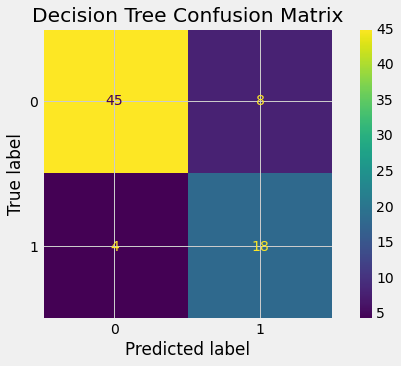

In [23]:
plot_confusion_matrix(model, test_X, test_y)
plt.title('Decision Tree Confusion Matrix')
plt.show()

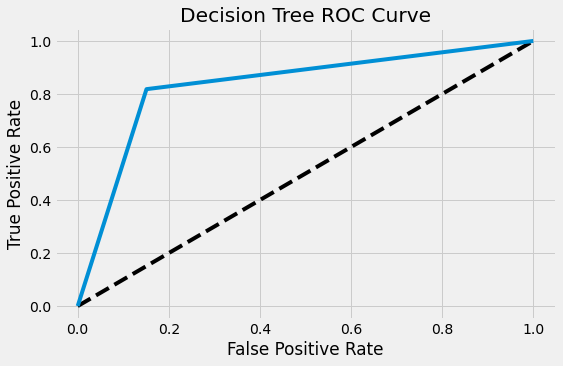

In [24]:
model = DecisionTreeClassifier(min_samples_split=2, class_weight={0:2,1:7}, random_state=13)
model.fit(train_X, train_y)
y_pred_prob = model.predict_proba(test_X)[:,1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='DT')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()

# Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(min_samples_split=2, class_weight={0:2,1:7}, random_state=13)
model.fit(train_X,train_y)
prediction=model.predict(test_X)
print('The accuracy of the Random Forest Classifier is', accuracy_score(prediction,test_y))

The accuracy of the Random Forest Classifier is 0.8933333333333333


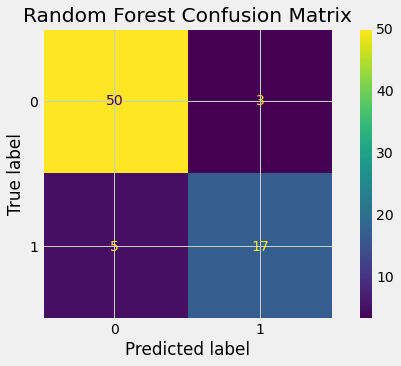

In [26]:
plot_confusion_matrix(model, test_X, test_y)
plt.title('Random Forest Confusion Matrix')
plt.show()

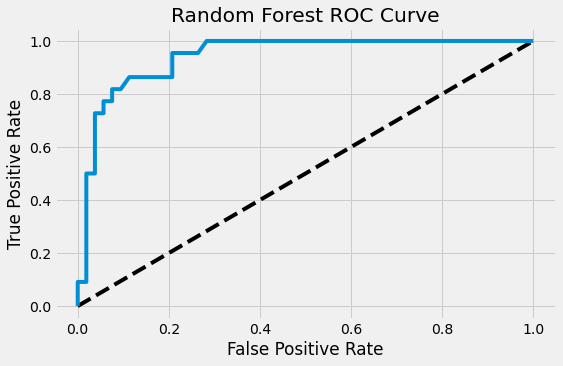

In [27]:
model = RandomForestClassifier(min_samples_split=2, class_weight={0:2,1:7}, random_state=13)
model.fit(train_X, train_y)
y_pred_prob = model.predict_proba(test_X)[:,1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

# Comparison of models

<ol style='font-size:18px'>
    <li>Random Forest provides a better accuracy(89.3%) than decision trees</li>
    <li>RF is more efficient in prediction the negative labels in the data as can be seen from the confusion matrices of the two models</li>
    <li>ROC score of RF is much better than DT</li>
</ol>

# Conclusion

<p style="font-size:18px">Do you fear a heart attack? Then obviouly make use of random forest. Also in case this notebook gave some hint on using the model, do leave a heart here. I mean an upvote :)</p>

<p style="font-size:18px">And let me know in comments for any improvement.</p>